<a href="https://colab.research.google.com/github/IvanTejeda/Painting-3D-models-using-Generative-AI/blob/main/Ivan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Paint 3D Game Objects Using Generative Al**

# Here is what I did in this project:


*   Rendered a 3D mesh of a cow with it's texture
*   Replaced the cow's texture with a different png image
*   Given prompt and texture image as inputs, generated new texture images using Stable Diffusion and ControlNet from HuggingFace
*   Rendered the 3D mesh of the cow with the AI generated texture images
*   Used ControlNet with prompt and *2D rendered images* as inputs, instead of prompt and texture image. This led to better AI generated images.
*   Developed algorithm to paint 3D object given AI generated 2D image from last step









In [ ]:
#Check version
import sys
import torch
print(torch.__version__)


I ran into a lot of issues building wheels for pytorch3D. So the solution I took was to go back to a version of pytorch3D 2.1 instead of 2.2 and then it worked. Another file in the repository explains the more detailed steps I took.

In [ ]:
#Run this code if the version is 2.2 and not 2.1
import os
import sys
import torch
import locale
#takes 2-3 minutes
!pip install torch==2.1.2 torchvision==0.16.2 torchaudio==2.1.2 --index-url https://download.pytorch.org/whl/cu121

Now what I did was:


*   Downloaded the necessary modules
*   Mounted my google drive
*   Loaded a cow mesh object
*   Initiliazed a camera, light, and functions to easily change orientation and resolution





In [ ]:
import os
import sys
import torch
import locale

# ==================
# install Pytorch3D
# ==================
need_pytorch3d=False
try:
    import pytorch3d
except ModuleNotFoundError:
    need_pytorch3d=True
if need_pytorch3d:
    if torch.__version__.startswith("2.1.") and sys.platform.startswith("linux"):
        # We try to install PyTorch3D via a released wheel.
        pyt_version_str=torch.__version__.split("+")[0].replace(".", "")
        version_str="".join([
            f"py3{sys.version_info.minor}_cu",
            torch.version.cuda.replace(".",""),
            f"_pyt{pyt_version_str}"
        ])
        !pip install fvcore iopath
        !pip install --no-index --no-cache-dir pytorch3d -f https://dl.fbaipublicfiles.com/pytorch3d/packaging/wheels/{version_str}/download.html
    else:
        # We try to install PyTorch3D from source.
        !pip install 'git+https://github.com/facebookresearch/pytorch3d.git'

# ==================
# install Diffusers
# ==================
!source '/content/drive/My Drive/dev/colab_env/bin/activate'; \
pip install accelerate; \
pip install diffusers==0.15.0; \

# ==================
# install OpenCV
# ==================
!pip install opencv-python

import cv2
import pytorch3d

# Mounting our google drive
# ==================
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# ==================

import os
import torch
import matplotlib.pyplot as plt

# Util function for loading meshes
from pytorch3d.io import load_objs_as_meshes, load_obj

# Data structures and functions for rendering
from pytorch3d.structures import Meshes
from pytorch3d.vis.plotly_vis import AxisArgs, plot_batch_individually, plot_scene
from pytorch3d.vis.texture_vis import texturesuv_image_matplotlib
from pytorch3d.renderer import (
    look_at_view_transform,
    FoVPerspectiveCameras,
    PointLights,
    DirectionalLights,
    Materials,
    RasterizationSettings,
    MeshRenderer,
    MeshRasterizer,
    SoftPhongShader,
    TexturesUV,
    TexturesVertex
)

# add path for demo utils functions
import sys
import os
sys.path.append(os.path.abspath(''))


# ==================

#checking if cuda is available for use
#CUDA is a parallel computing platform and API model created by NVIDIA for computing on its gpus
#if so, sets device to be the first GPU ('cuda:0') using pytorch
# Setup
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    torch.cuda.set_device(device) #ensures that PyTorch will perform all tensor operations on the specified GPU
else:
    device = torch.device("cpu")

# Load 3D obj file into mesh format
# Load meshes from a list of obj files using the load_obj function and return them as a Meshes Object.
#device=device specifies the computing device (GPU or CPU) where the mesh will be processed and stored


mesh = load_objs_as_meshes(["/content/drive/MyDrive/dev/cow.obj"], device=device)



# ==================

# Initialize a camera.
# With world coordinates +Y up, +X left and +Z in, the front of the cow is facing the -Z direction.
# So we move the camera by 180 in the azimuth direction so it is facing the front of the cow.
#calculates the rotation R and translation T matrices for a camera that looksa t an object from a specific viewpoint
# (distance, elevation angle, azimuth angle)
R, T = look_at_view_transform(2.5, 0, 180)
cameras = FoVPerspectiveCameras(device=device, R=R, T=T)
def changeOrientation(y,x,z):
  R,T = look_at_view_transform(y,x,z)
  new_cameras = FoVPerspectiveCameras(device=device, R=R, T=T)
  new_renderer = MeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=new_cameras,
        raster_settings=raster_settings
    ),
    shader=SoftPhongShader(
        device=device,
        cameras=new_cameras,
        lights=lights
    )
)
  return new_renderer

def changeResolution(res):
  new_raster_settings = RasterizationSettings(
    image_size=res,
    blur_radius=0.0,
    faces_per_pixel=1,
)
  return new_raster_settings



raster_settings = RasterizationSettings(
    image_size=512,
    blur_radius=0.0,
    faces_per_pixel=1,
)

# Place a point light in front of the object. As mentioned above, the front of the cow is facing the
# -z direction.
lights = PointLights(device=device, location=[[0.0, 0.0, -3.0]])

# Create a Phong renderer by composing a rasterizer and a shader. The textured Phong shader will
# interpolate the texture uv coordinates for each vertex, sample from a texture image and
# apply the Phong lighting model
renderer = MeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=cameras,
        raster_settings=raster_settings
    ),
    shader=SoftPhongShader(
        device=device,
        cameras=cameras,
        lights=lights
    )
)


Here are some renders of the cow mesh with it's texture

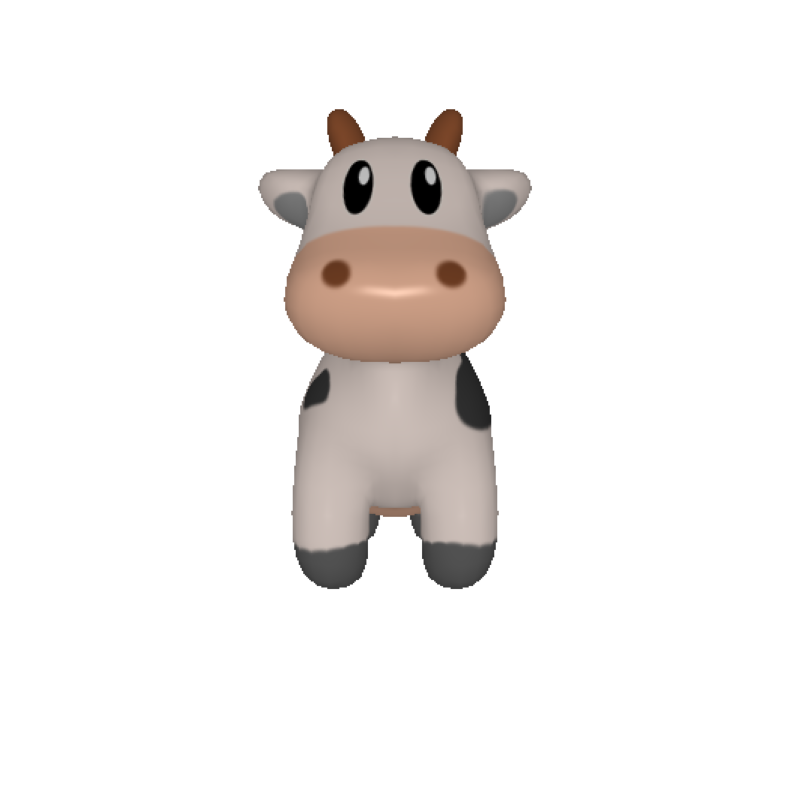

In [3]:
raster_settings = changeResolution(512)
renderer = changeOrientation(2.5,0,180)
images = renderer(mesh)
plt.figure(figsize=(10, 10))
plt.imshow(images[0, ..., :3].cpu().numpy())
plt.axis("off");

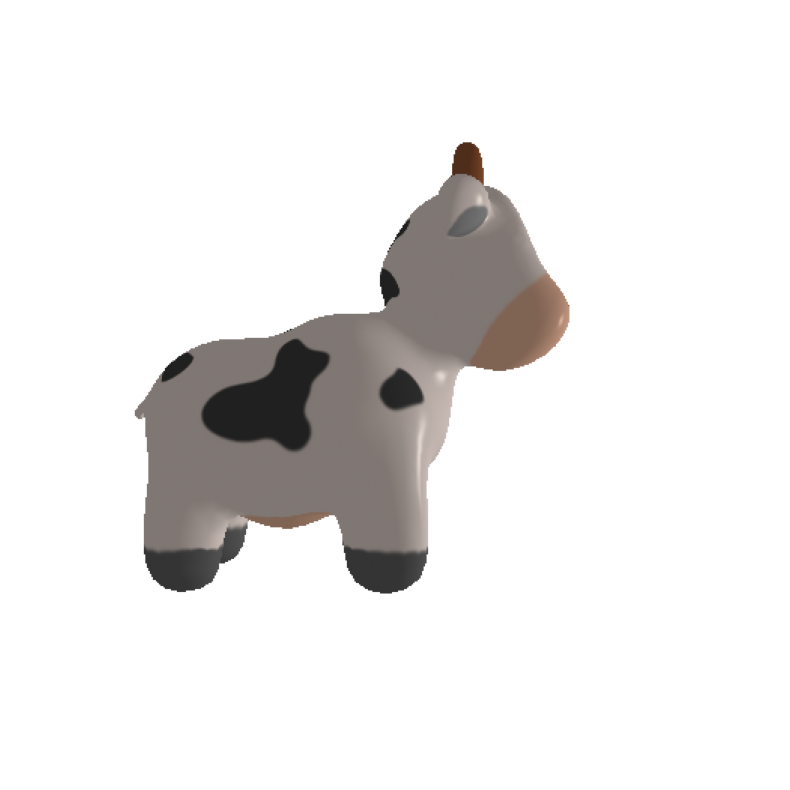

In [4]:
raster_settings = changeResolution(512)
renderer = changeOrientation(2.7,0,90)
images = renderer(mesh)
plt.figure(figsize=(10, 10))
plt.imshow(images[0, ..., :3].cpu().numpy())
plt.axis("off");

To change textures, I needed to:

*   Grab the texture indices for each face from the mesh
*   Grab the UV texture coordinates for the texture
*   Load the new texture image
*   Convert the texture image to a tensor
*   Swaped axes of texture image tensor to align with the format of using TextureUV
*   Used TextureUV function to change the mesh texture to our new texture image. Now you can see the cow is now pink.





In [5]:
from pytorch3d.io import load_obj
verts, face, aux = load_obj("/content/drive/MyDrive/dev/cow.obj", load_textures=True, device=device)
#verts: The vertices of the loaded mesh. Vertices are points in 3D space that, when connected, form the mesh's surface.
# faces: The faces of the mesh. A face is defined by indices into the verts array, indicating which vertices form that face.
# aux: Auxiliary data, including texture information when load_textures=True is specified. This can include UV coordinates for texture mapping and the indices of textures for each face.

In [6]:
faces_uvs = face.textures_idx #This line extracts the texture indices for each face from the faces object. textures_idx contains indices into the UV texture coordinates, specifying how textures should be applied to each face of the mesh.
verts_uvs = aux.verts_uvs #This line retrieves the UV texture coordinates from the auxiliary data returned by load_obj. UV coordinates map points on the mesh's surface to points on a 2D texture image, allowing the image to be applied to the mesh as a texture.

#faces are triangles
# U and V coordinates

In [7]:
from PIL import Image
from torchvision import transforms as T


# Read image with PIL
texture_image = Image.open('/content/drive/MyDrive/dev/cow_texture_pink1.png')

#swap axes to match format for TexturesUV
img2 = T.ToTensor()(texture_image)
img2 = torch.swapaxes(img2, 0,1)
img2 = torch.swapaxes(img2, 1,2)
img2 = img2.to(device)



In [8]:
mesh.textures = TexturesUV(maps=[img2], faces_uvs=[faces_uvs], verts_uvs=[verts_uvs])

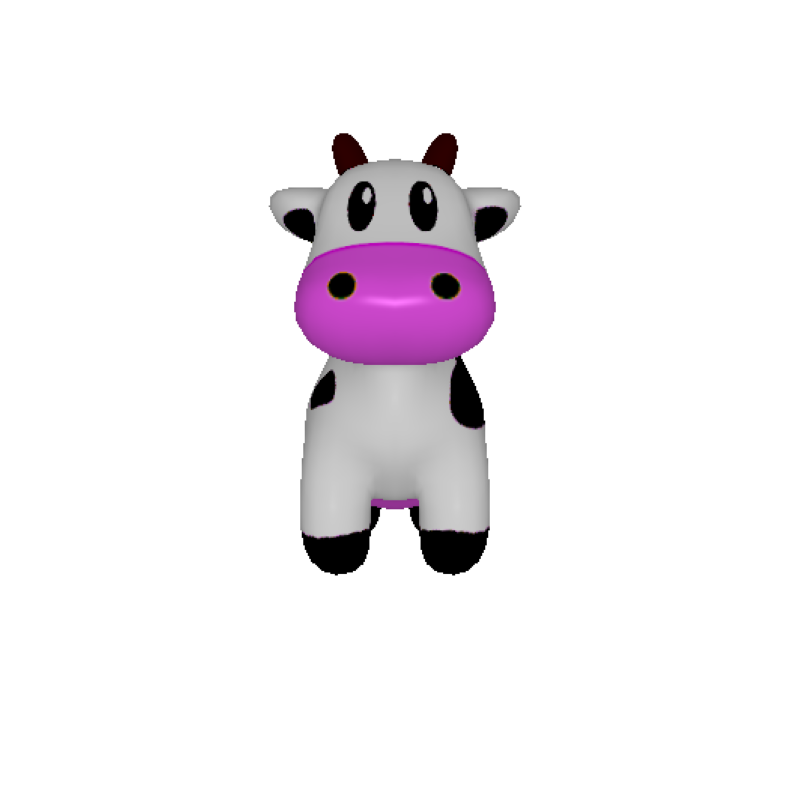

In [9]:
raster_settings = changeResolution(512)
renderer = changeOrientation(2.7,0,180)

images = renderer(mesh)
plt.figure(figsize=(10, 10))
plt.imshow(images[0, ..., :3].cpu().numpy())
plt.axis("off");

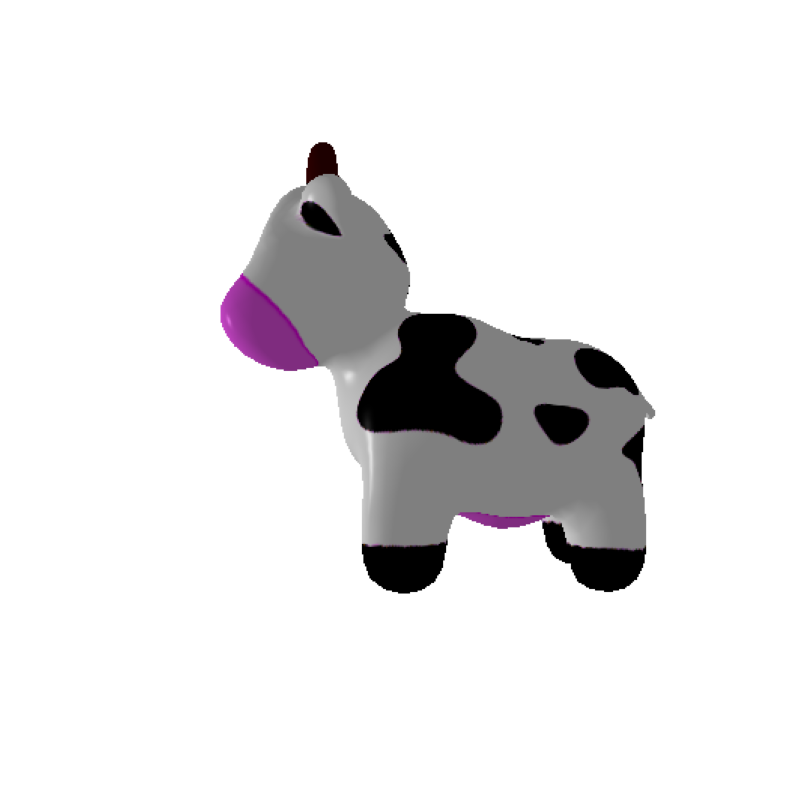

In [10]:
raster_settings = changeResolution(512)
renderer = changeOrientation(2.7,0,270)

images = renderer(mesh)
plt.figure(figsize=(10, 10))
plt.imshow(images[0, ..., :3].cpu().numpy())
plt.axis("off");

Now to test Stable Diffusion, I downloaded the necessary modules.

In [ ]:
# Loading checkpoint into the AutoPipelineForImage2Image class; this pipeline automatically handles loading the correct pipeline class based on the checkpoint:
#image to image
import torch
import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding
!pip install --upgrade diffusers
from diffusers import AutoPipelineForImage2Image
from diffusers.utils import load_image, make_image_grid
#takes 3-4 minutes
pipeline = AutoPipelineForImage2Image.from_pretrained(
    "kandinsky-community/kandinsky-2-2-decoder", torch_dtype=torch.float16, use_safetensors=True
)
pipeline.enable_model_cpu_offload()

And now I generated an image using a prompt, and our texture image as inputs

In [ ]:
init_image = load_image("/content/drive/MyDrive/dev/cow_texture_pink1.png")

In [ ]:
prompt = "Lego Batman"
image = pipeline(prompt, image=init_image).images[0]


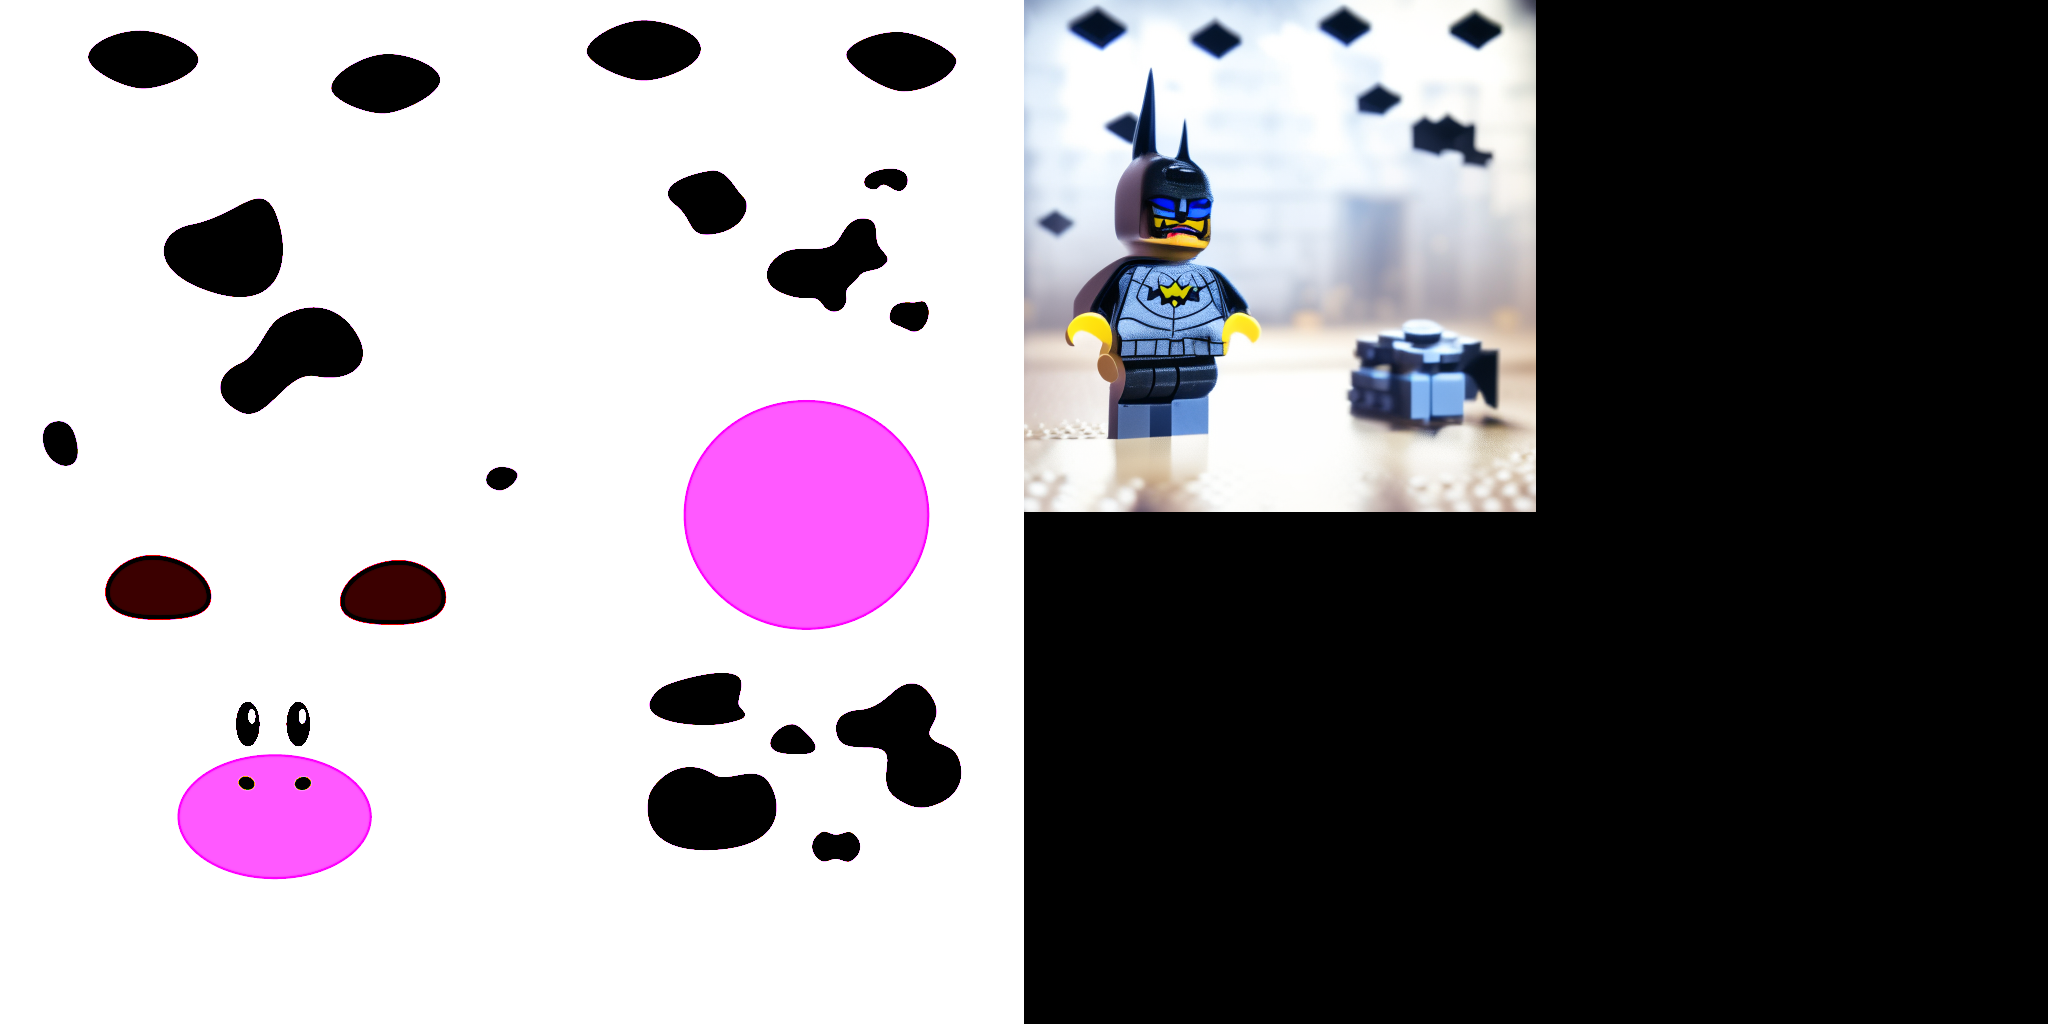

In [ ]:
make_image_grid([init_image, image], rows=1, cols=2)

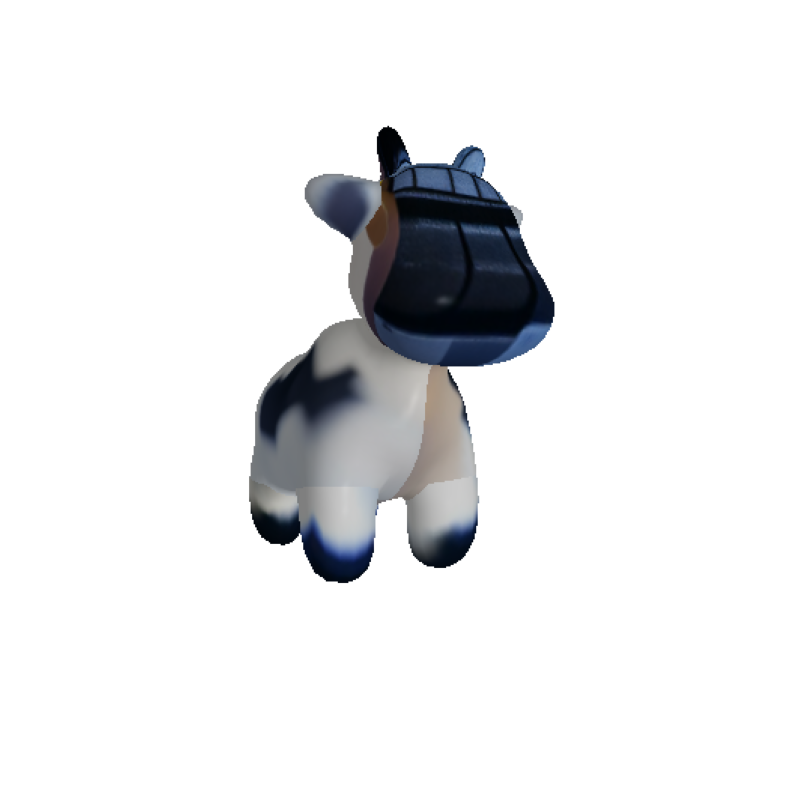

In [ ]:
i = T.ToTensor()(image)
i = torch.swapaxes(i, 0, 1)
i = torch.swapaxes(i, 1, 2)
i = i.to(device)

mesh.textures = TexturesUV(maps=[i], faces_uvs=[faces_uvs], verts_uvs=[verts_uvs])
raster_settings = changeResolution(512)
renderer = changeOrientation(2.7,0,150)

images = renderer(mesh)
plt.figure(figsize=(10, 10))
plt.imshow(images[0, ..., :3].cpu().numpy())
plt.axis("off");

As you can see, the image would not work as a texture image. This is because the generated image does not keep the relevant information of the texture image such as the outline and edges.

So now, we try ControlNet. The textures will look "better", in terms of applying it to the mesh. This is because we use a canny image as an input instead of the texture image.

The canny image uses Canny edge detection method to identify the edges of the texture image, thus giving the ControlNet algorithm a better idea of how to create an appropriate texture image.

In [12]:

from diffusers.utils import load_image, make_image_grid
from PIL import Image
import cv2
import numpy as np

original_image = load_image(
    "/content/drive/MyDrive/dev/cow_texture_pink1.png"
)

image = np.array(original_image)


low_threshold = 100
high_threshold = 200

image = cv2.Canny(image, low_threshold, high_threshold)
image = image[:, :, None]
image = np.concatenate([image, image, image], axis=2)
canny_image = Image.fromarray(image)



In [ ]:
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel, UniPCMultistepScheduler
import torch

controlnet = ControlNetModel.from_pretrained("lllyasviel/sd-controlnet-canny", torch_dtype=torch.float16, use_safetensors=True)
pipe = StableDiffusionControlNetPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5", controlnet=controlnet, torch_dtype=torch.float16, use_safetensors=True
)

pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)
pipe.enable_model_cpu_offload()

Here is our texture image, canny image, and generated image side by side

In [ ]:
output = pipe(
    "Lego Batman", image=canny_image
).images[0]


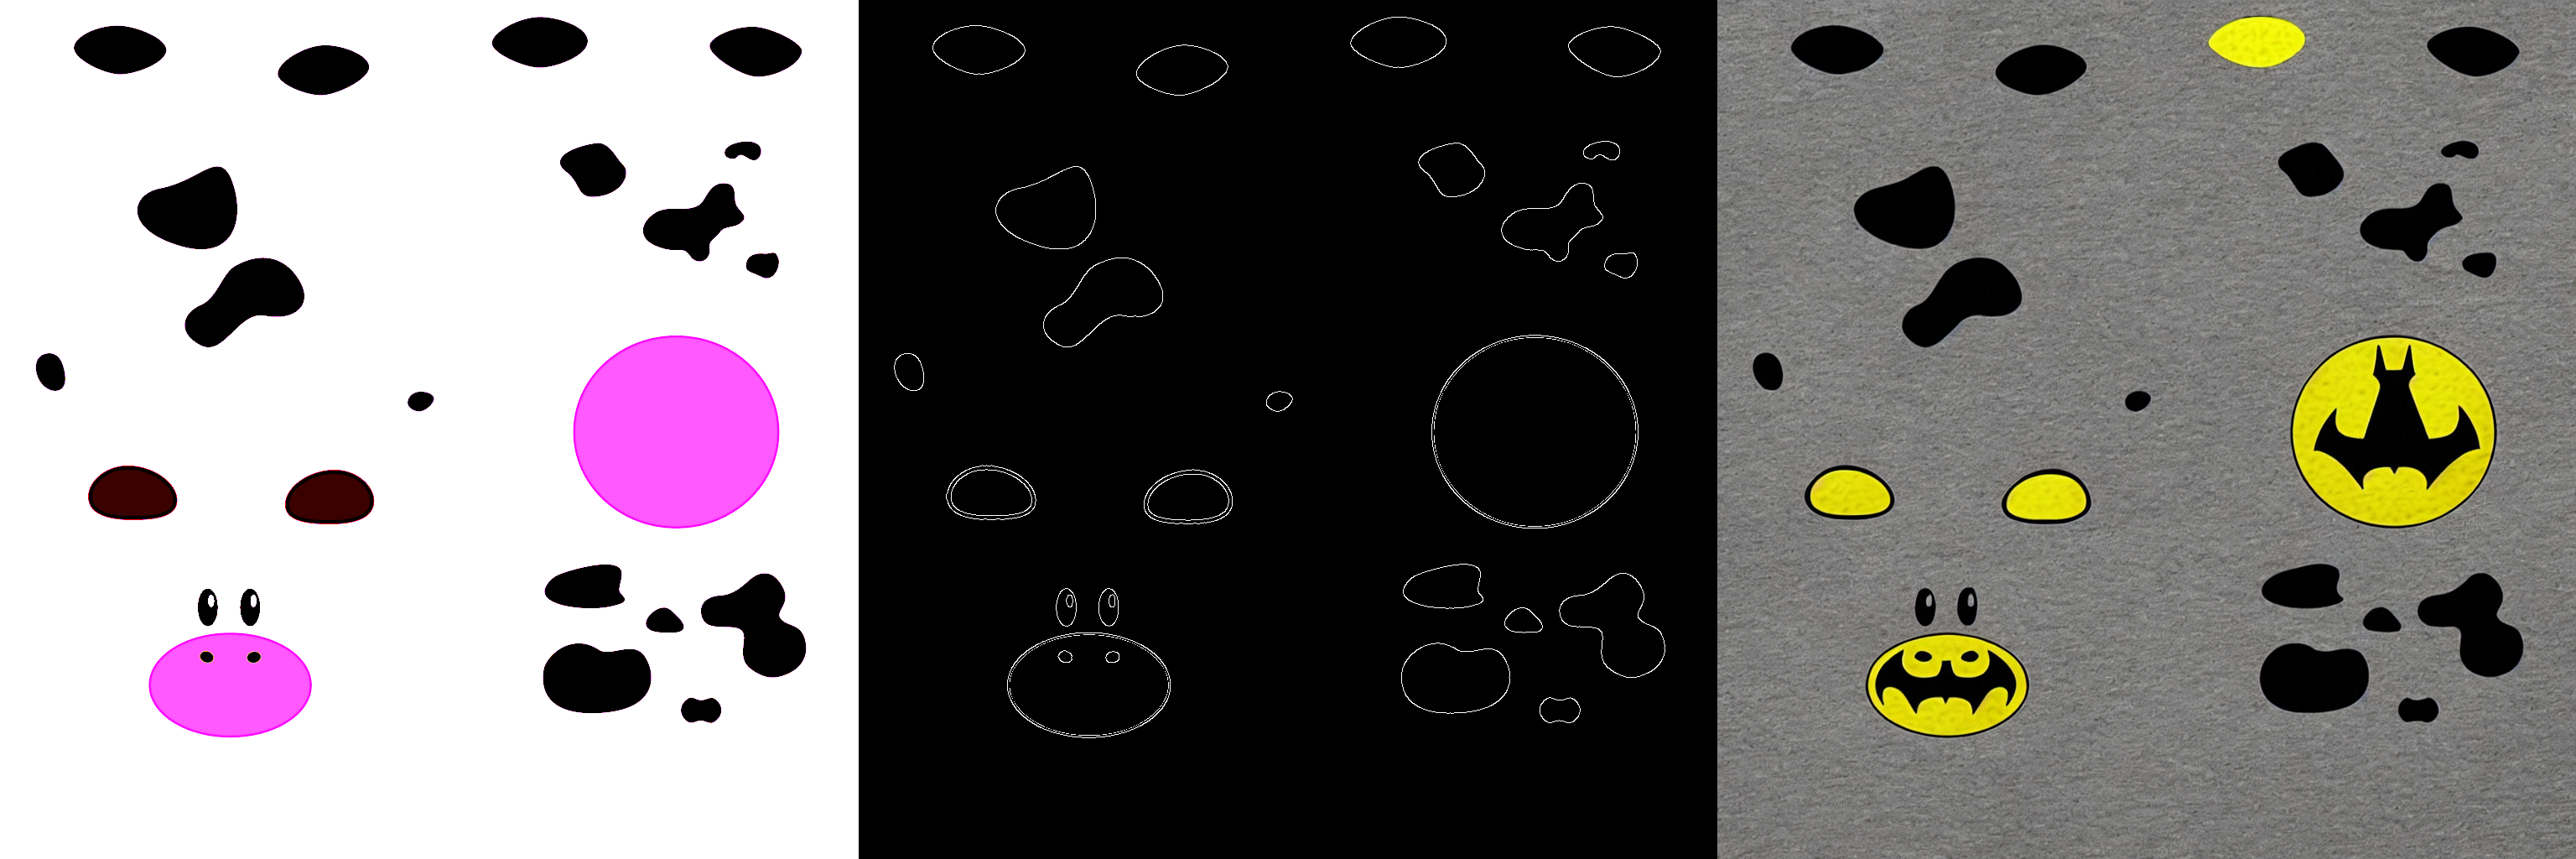

In [18]:
make_image_grid([original_image, canny_image, output], rows=1, cols=3)

In [19]:
def hf_image_to_text(image):
  image = T.ToTensor()(image)
  image = torch.swapaxes(image, 0, 1)
  image = torch.swapaxes(image, 1, 2)
  image = image.to(device)
  return image

And here it is rendered, it fits better

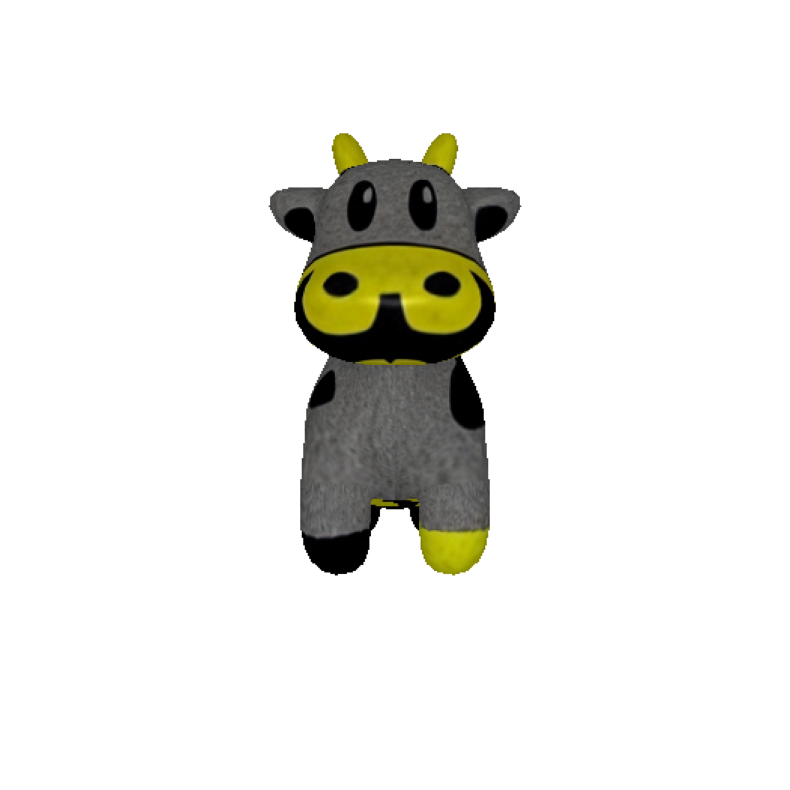

In [22]:
x = hf_image_to_text(output)
mesh.textures = TexturesUV(maps=[x], faces_uvs=[faces_uvs], verts_uvs=[verts_uvs])
raster_settings = changeResolution(512)
renderer = changeOrientation(2.7,0,180)

images = renderer(mesh)
plt.figure(figsize=(10, 10))
plt.imshow(images[0, ..., :3].cpu().numpy())
plt.axis("off");

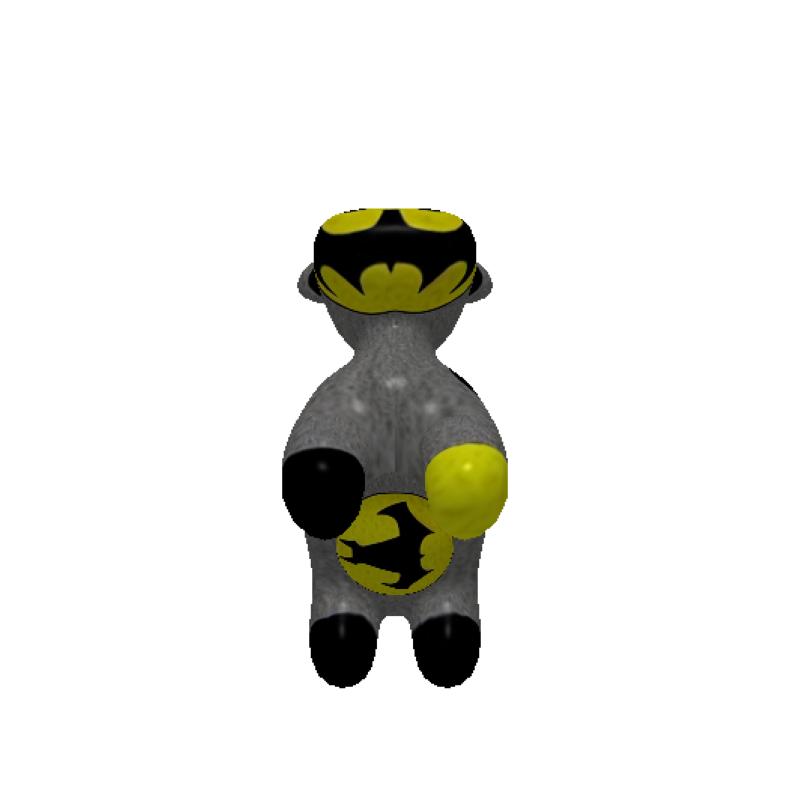

In [27]:
x = hf_image_to_text(output)
mesh.textures = TexturesUV(maps=[x], faces_uvs=[faces_uvs], verts_uvs=[verts_uvs])
raster_settings = changeResolution(512)
renderer = changeOrientation(2.7,300,180)

images = renderer(mesh)
plt.figure(figsize=(10, 10))
plt.imshow(images[0, ..., :3].cpu().numpy())
plt.axis("off");

But the texture image itself looks terrible, even if it fits the 3D object better. The ControlNet algorithm has trouble creating an image from the canny image because it is not used to seeing images in that very specific edge format. It would be better if it was able to generate an image from a more familiar image.

This familiar image is a 2D render image. We will create a blank cow mesh, render it from a specific angle, and use that render image as an input to ControlNet.

In [28]:
#Create blank mesh with no texture image
mesh2 = load_objs_as_meshes(["/content/drive/MyDrive/dev/cow.obj"], device=device, load_textures = False)
blank_image = Image.open('/content/drive/MyDrive/dev/Gray.png')
x = hf_image_to_text(blank_image)
mesh2.textures = TexturesUV(maps=[x], faces_uvs=[faces_uvs], verts_uvs=[verts_uvs])


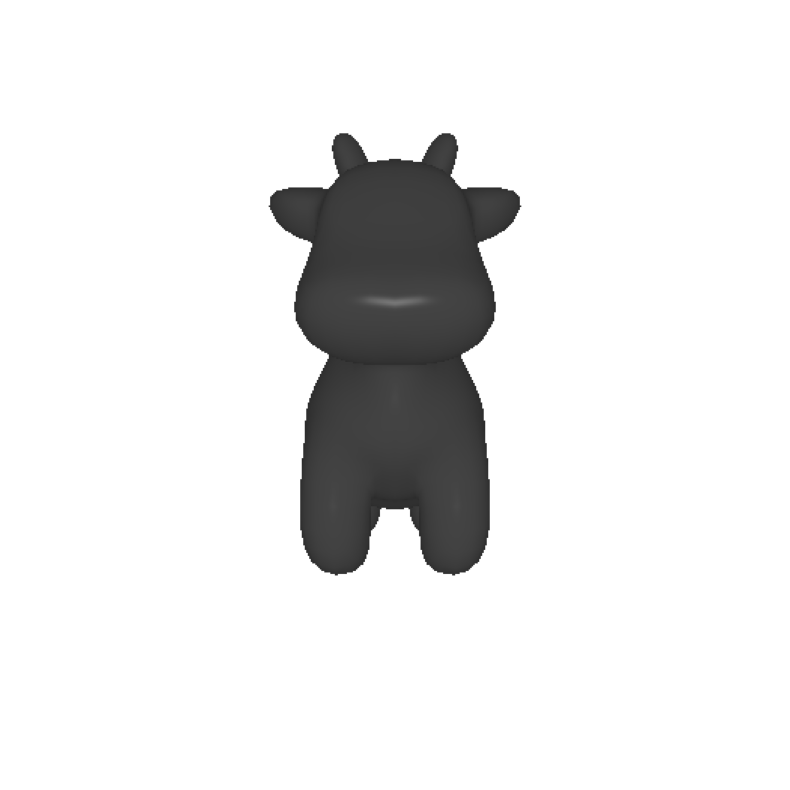

In [29]:
raster_settings = changeResolution(512)
renderer = changeOrientation(2.7,0,180)
images = renderer(mesh2)
plt.figure(figsize=(10, 10))
plt.imshow(images[0, ..., :3].cpu().numpy())
plt.axis("off");

In [30]:
from diffusers.utils import load_image, make_image_grid
from PIL import Image
import cv2
import numpy as np


# image = np.array(images)
image = images[0, ..., :3].cpu().numpy()

low_threshold = 50
high_threshold = 150
image = (image * 255).astype(np.uint8)
image = cv2.Canny(image, low_threshold, high_threshold)

image = image[:, :, None]
image = np.concatenate([image, image, image], axis=2)
canny_image = Image.fromarray(image)


In [ ]:
output = pipe(
    "Lego Batman", image=canny_image
).images[0]


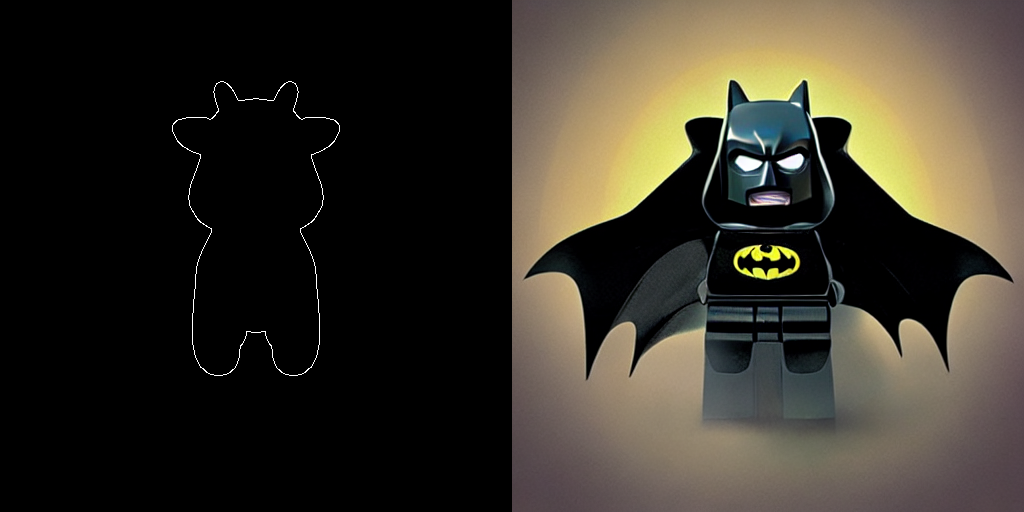

In [34]:
make_image_grid([canny_image, output], rows=1, cols=2)

Now, since ControlNet has seen more images that are in the general shape of a cow, it is able to give us a much better looking image.

But now we need to "paint" that image onto our 3D object from that specific camera angle. Here are the steps on how we do this:


*   Render blank 3D cow mesh from the same camera angle

*   Compute the loss (difference in colors) between the ControlNet image (target image) and the rendered 3D cow mesh (source image)

*   Backpropogate the information using .backward(). This will update the texture image using the optimizer function.

*   Continue updating the texture image until the loss is 0 or at a fixed number



In [35]:
target_image = output
rendered_image = images
target_image = hf_image_to_text(target_image)
rendered_image = rendered_image[0 ,..., :-1]


In [36]:
mesh2 = load_objs_as_meshes(["/content/drive/MyDrive/dev/cow.obj"], device=device, load_textures = False)

texture_initial = torch.full([512, 512, 3], 0.5, device=device, requires_grad=True)
mesh2.textures = TexturesUV(maps=[texture_initial], faces_uvs=[faces_uvs], verts_uvs=[verts_uvs])

ren = renderer(mesh2)
ren = ren[0 ,..., :-1]



In [ ]:
# OPTIMIZER LOOP

texture_initial = torch.full([512, 512, 3], 0.5, device=device, requires_grad=True) #texture to be updated

optimizer = torch.optim.SGD([texture_initial], lr=100000.0, momentum=0.9)

for i in range(500):

  optimizer.zero_grad()
  mesh2.textures = TexturesUV(maps=[texture_initial], faces_uvs=[faces_uvs], verts_uvs=[verts_uvs])
  ren = renderer(mesh2)
  ren = ren[0 ,..., :-1]
  loss_rgb = (( ren - target_image)**2).mean() #find loss between source and target images


  loss_rgb.backward()
  optimizer.step()

plt.figure(figsize=(10, 10))
plt.imshow(texture_initial.detach().cpu().numpy())
plt.axis("off");

tensor = texture_initial.detach().cpu().numpy()

tensor = tensor*255
plt.figure(figsize=(10, 10))
plt.imshow(tensor)
plt.axis("off");
tensor = np.array(tensor, dtype=np.uint8) #might be here
plt.figure(figsize=(10, 10))
plt.imshow(tensor)
plt.axis("off");
img = Image.fromarray(tensor)

img.save('/content/drive/MyDrive/dev/cow_texture.png')





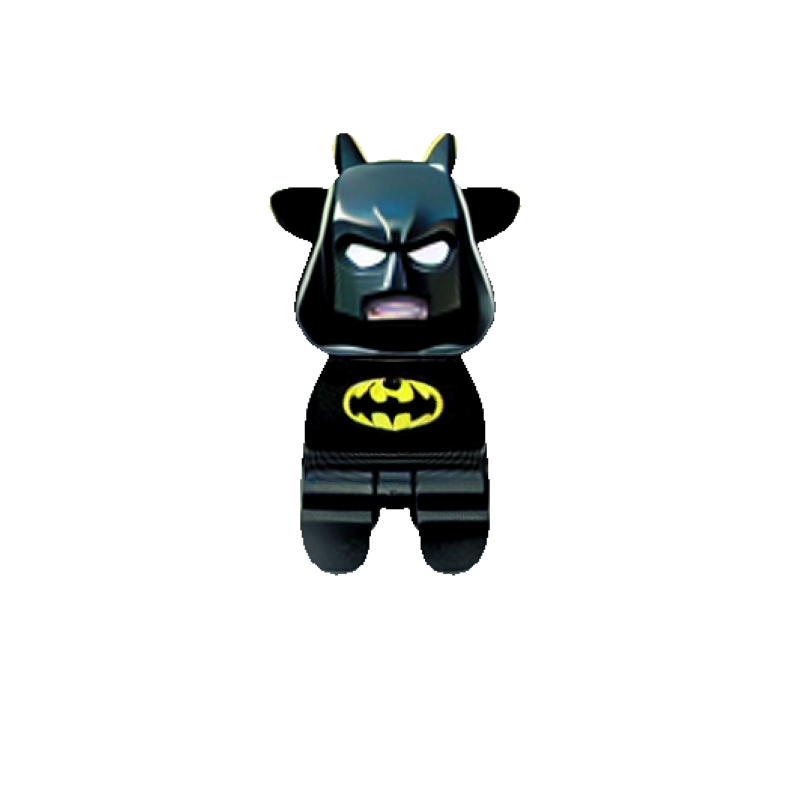

In [38]:
images = renderer(mesh2)
plt.figure(figsize=(10, 10))
plt.imshow(images[0, ..., :3].cpu().detach().numpy())
plt.axis("off");

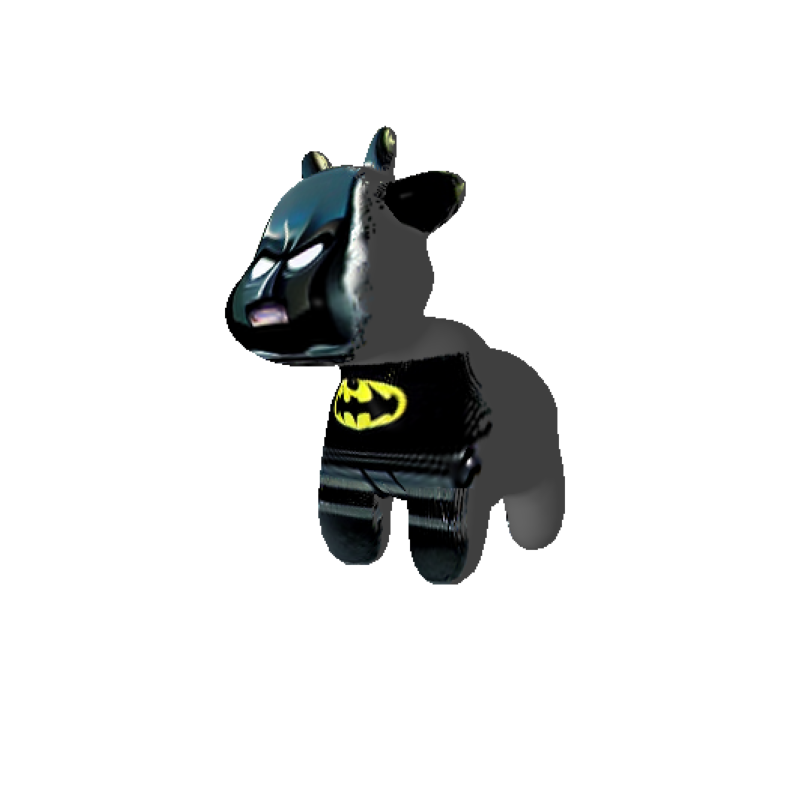

In [41]:
renderer = changeOrientation(2.7,0,220)
images = renderer(mesh2)
plt.figure(figsize=(10, 10))
plt.imshow(images[0, ..., :3].cpu().detach().numpy())
plt.axis("off");

Now, we have sucessfully painted a Lego Batman design on to the 3D object. It is important to note that we essentially just "stamped" and image on to one perspective of the mesh. The rest of the mesh remains "unpainted".